# Data Processing and Modeling

## In this notebook, we will process the data and build a model to predict the outcome of the matches.

### Importing Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import joblib
import umap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [11]:
# Path to the dataset
dataset_path = "/home/matthieu/UbuntuData/PycharmProjects/MelodAI/data/raw/dataset.csv"

# Load the dataset
dataframe = pd.read_csv(dataset_path, low_memory=False)

# Remove rows with null values
df = dataframe.dropna()

# Convert the 'explicit' column from boolean to integer (0 or 1)
df.loc[:, 'explicit'] = df['explicit'].astype(int)

# Initialize a LabelEncoder for the 'track_genre' column
label_encoder = LabelEncoder()
df = df.copy()

# Encode the 'track_genre' column and add it as a new column 'track_genre_encoded'
df.loc[:, 'track_genre_encoded'] = label_encoder.fit_transform(df['track_genre'])

# List of columns that are not useful for processing and training
unexploitable_columns = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre']

# DataFrame containing only the unexploitable columns
df_unexploitable = df[unexploitable_columns]

# DataFrame without the unexploitable columns
df_exploitable = df.drop(columns=unexploitable_columns)

/tmp/ipykernel_8638/2519851572.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, 'explicit'] = df['explicit'].astype(int)


In [12]:
df_exploitable.columns

Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre_encoded'],
      dtype='object')

### Data Processing

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_exploitable.drop(columns=['track_genre_encoded']))

# Create a dataframe with the scaled features
df_std_scaler = pd.DataFrame(scaled_features, columns=df_exploitable.columns[:-1])  # Les colonnes sans la target

# Add the target column
df_std_scaler['track_genre_encoded'] = df_exploitable['track_genre_encoded']

# drop null values
df_std_scaler = df_std_scaler.dropna()

# UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_components=6)
df_umap = umap_reducer.fit_transform(df_std_scaler)

# Create a DataFrame
df_umap = pd.DataFrame(df_umap, columns=['UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5', 'UMAP6'])

# Concatenate with the target
df_umap = pd.concat([df_umap, df['track_genre_encoded']], axis=1)

# Drop null values
df_umap = df_umap.dropna()

### Data Modeling

In [14]:
# Split the data into features and target
# Features: all columns except 'track_genre_encoded'
# Target: 'track_genre_encoded' column
X = df_umap.drop(columns=['track_genre_encoded'])  # Features
y = df_umap['track_genre_encoded']  # Target

# Initial split with stratified sampling (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

# Further split the training set to create a validation set (10% of the training set)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.1, 
                                                  stratify=y_train, 
                                                  random_state=42)

In [15]:
# Random Forest Classifier
rf = RandomForestClassifier()
print(f"Training Random Forest model...")
rf.fit(X_train, y_train)
print(f"Training complete!")

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

print(f"Predictions: {y_pred}")

Training Random Forest model...
Training complete!
Accuracy: 0.8803070175438596
Precision: 0.8810737833042301
Recall: 0.8803070175438596
Predictions: [ 14.  23.  16. ... 111.  29.  40.]


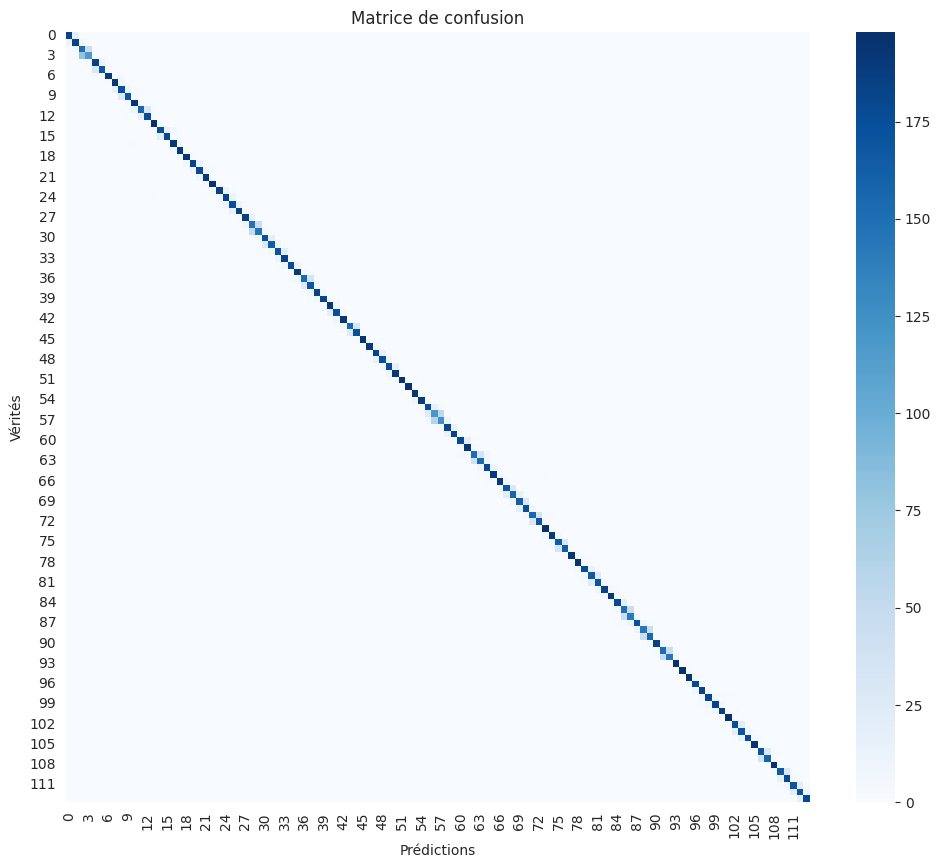

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion')
plt.show()

In [17]:
def save_classification_report(y_test, y_pred, file_path):
    report = classification_report(y_test, y_pred)
    
    with open(file_path, 'w') as file:
        file.write(report)
    print(f"Le rapport a été sauvegardé dans {file_path}")

save_classification_report(y_test, y_pred, "/home/matthieu/UbuntuData/PycharmProjects/MelodAI/non_official_models/classification_report.txt")


Le rapport a été sauvegardé dans /home/matthieu/UbuntuData/PycharmProjects/MelodAI/non_official_models/classification_report.txt
